## Install Relevant Libraries

In [0]:
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn

## Import Relevant Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Read Data

In [54]:
df = pd.read_csv("Kaggle_Salary.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Overview

Taking a look at the data:

In [55]:
df.head()

Time from Start to Finish (seconds)     Q1  ... Q10_Encoded    Q10_buckets
0                                  510  22-24  ...           3  30,000-39,999
1                                  423  40-44  ...           0        0-9,999
2                                  391  40-44  ...          14       >250,000
3                                  392  22-24  ...           0        0-9,999
4                                  470  50-54  ...           6  60,000-69,999

[5 rows x 248 columns]

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12497 entries, 0 to 12496
Columns: 248 entries, Time from Start to Finish (seconds) to Q10_buckets
dtypes: int64(30), object(218)
memory usage: 23.6+ MB


## Data Cleaning

### Missing Data

First, the dataset is checked for any missing data using a heatmap. 

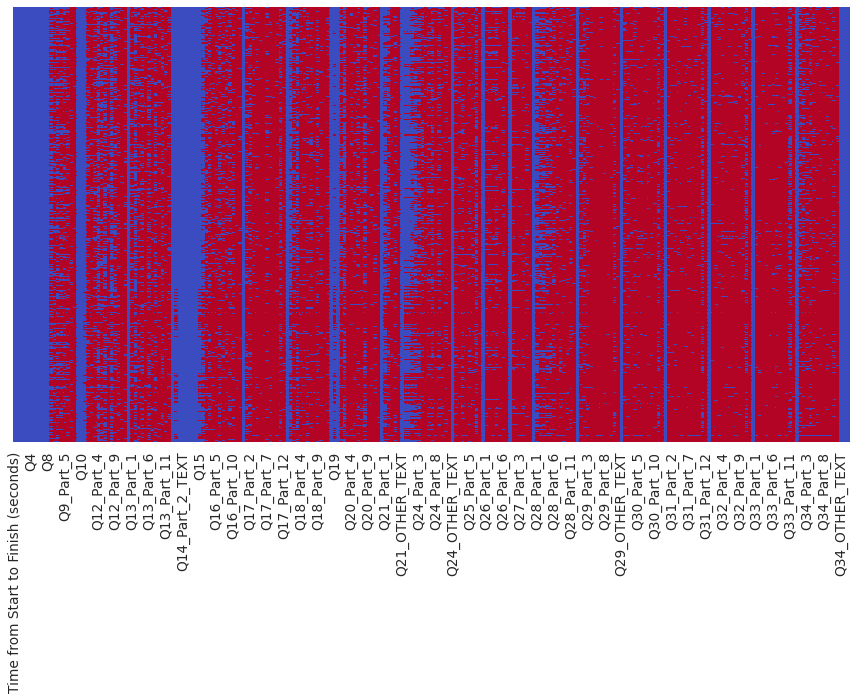

In [57]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)

There appears to be null values in almost all of the features. Taking a closer look at those features and their corresponding questions in the raw dataset, most of the null values are under "Select all that apply" questions.

#### Null Values in "Select all that apply" Questions

For these questions, the null values simply mean that a survey respondent did not select that given option. Q9 and its parts are displayed below as an example.

In [58]:
df.iloc[:, 11:20].head()

Q9_Part_1  ... Q9_OTHER_TEXT
0                                                NaN  ...            -1
1  Analyze and understand data to influence produ...  ...            -1
2                                                NaN  ...            -1
3                                                NaN  ...            -1
4                                                NaN  ...            -1

[5 rows x 9 columns]

Justification: As a result of the observed situation above, these null values are replaced with "0". Using a for loop, the replacement only occurs in columns where their column names have more than 4 letters, a characteristic that they belong to a "Select all that apply" question. 

Impact: The filled values should help to make a better analysis by filling in the missing information obtained from the survey. 

In [0]:
# Set value
col_names = df.columns.tolist()

for i in range(1, df.shape[1] - 2):
  if len(col_names[i]) > 4:
    df.iloc[:, i] = df.iloc[:, i].fillna(0)

In [60]:
# Verify
col_names = [name for name in col_names if len(name) > 4]
print(df[col_names].isnull().sum().to_string())

Time from Start to Finish (seconds)    0
Q2_OTHER_TEXT                          0
Q5_OTHER_TEXT                          0
Q9_Part_1                              0
Q9_Part_2                              0
Q9_Part_3                              0
Q9_Part_4                              0
Q9_Part_5                              0
Q9_Part_6                              0
Q9_Part_7                              0
Q9_Part_8                              0
Q9_OTHER_TEXT                          0
Q12_Part_1                             0
Q12_Part_2                             0
Q12_Part_3                             0
Q12_Part_4                             0
Q12_Part_5                             0
Q12_Part_6                             0
Q12_Part_7                             0
Q12_Part_8                             0
Q12_Part_9                             0
Q12_Part_10                            0
Q12_Part_11                            0
Q12_Part_12                            0
Q12_OTHER_TEXT  

#### Null Values in Other Questions

We then take a look at the remaining features that have null values.

In [61]:
# Find features with null values and count how many
null_cols = df.columns[df.isnull().any()]
df[null_cols].isnull().sum()

Q11     247
Q14    1045
Q15    1075
Q19    1844
Q22    1947
Q23    1956
dtype: int64

In [62]:
null_cols = ['Q11', 'Q14', 'Q15', 'Q19', 'Q22', 'Q23']
df[null_cols].head()

Q11  ...          Q23
0           $0 (USD)  ...    1-2 years
1  > $100,000 ($USD)  ...          NaN
2    $10,000-$99,999  ...    2-3 years
3           $0 (USD)  ...    < 1 years
4    $10,000-$99,999  ...  10-15 years

[5 rows x 6 columns]

These values may be missing due to some survey respondents thinking that the associated questions are not applicable to them. For example, some respondents may have never heard of TensorFlow as asked in Q23 and so did not answer this question. Furthermore, it is also possible that some survey respondents felt the options offered didn't match what they had in mind and did not want to provide a separate text answer. Lastly, some survey respondents may have accidentally missed a question.

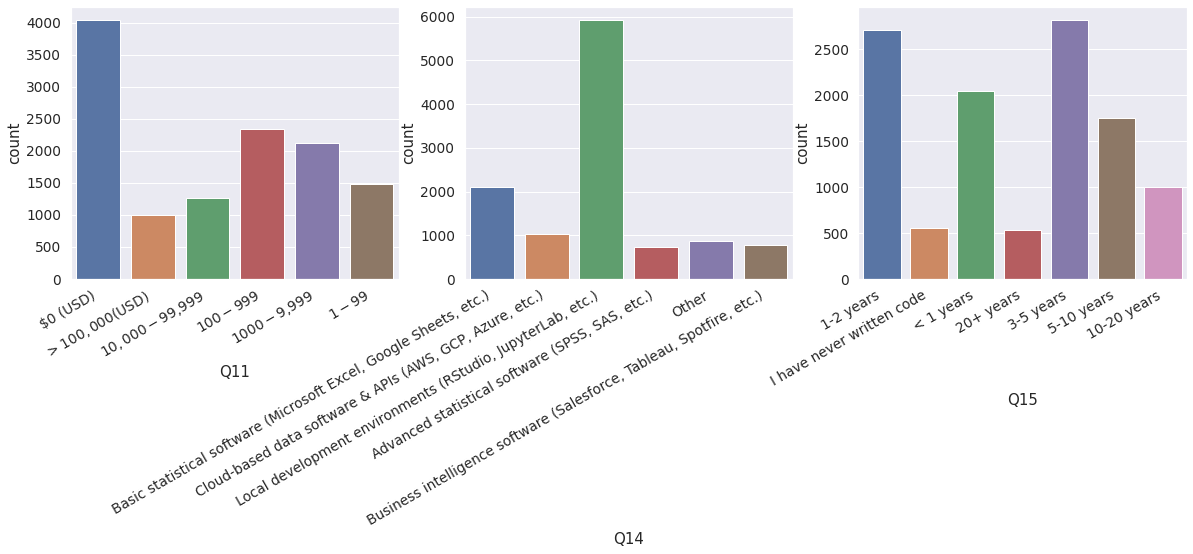

In [63]:
# Plotting the data in the columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
plt1 = sns.countplot(x='Q11', data=df, ax=ax1).set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')
plt2 = sns.countplot(x='Q14', data=df, ax=ax2).set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')
plt3 = sns.countplot(x='Q15', data=df, ax=ax3).set_xticklabels(ax3.get_xticklabels(), rotation=30, ha='right')
plt.show()

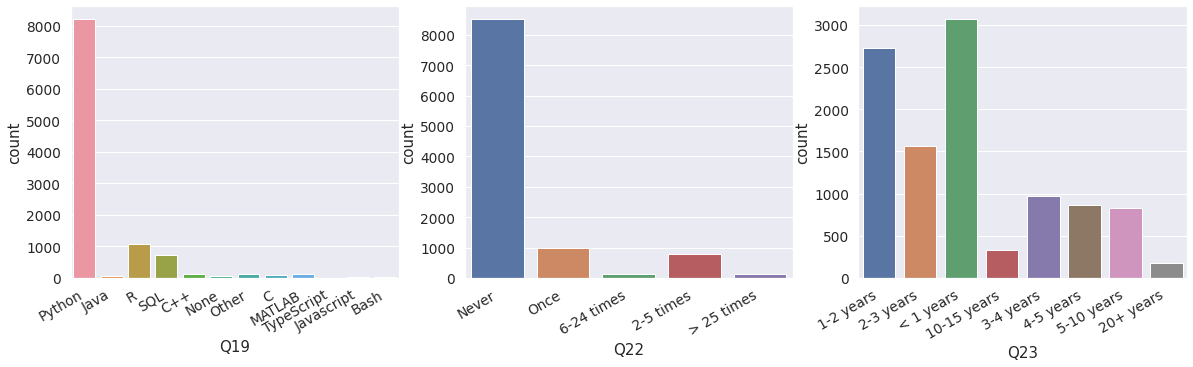

In [64]:
# Plotting the data in the columns
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20,5))
plt4 = sns.countplot(x='Q19', data=df, ax=ax4).set_xticklabels(ax4.get_xticklabels(), rotation=30, ha='right')
plt5 = sns.countplot(x='Q22', data=df, ax=ax5).set_xticklabels(ax5.get_xticklabels(), rotation=30, ha='right')
plt5 = sns.countplot(x='Q23', data=df, ax=ax6).set_xticklabels(ax6.get_xticklabels(), rotation=30, ha='right')
plt.show()

Justification: The columns contain ordinal or categorical data with less than 20% of missing values. Also, most of the columns have a clear most frequent response. Therefore, the mode is representative of the columns and is used to fill in the null values. 

Impact: Although filling in null values with the mode isn't as great as having original data, this is better than dropping data points entirely, which could lead to poor model predictions later on. However, imputation may lead to biased or misleading results, potentially impacting our analysis. 

In [0]:
# Set values with mode for each column
df = df.fillna(df[null_cols].mode().iloc[0])

In [66]:
# Verify
df[null_cols].isnull().sum()

Q11    0
Q14    0
Q15    0
Q19    0
Q22    0
Q23    0
dtype: int64

The heatmap also confirms that there are no more missing values in the dataset.

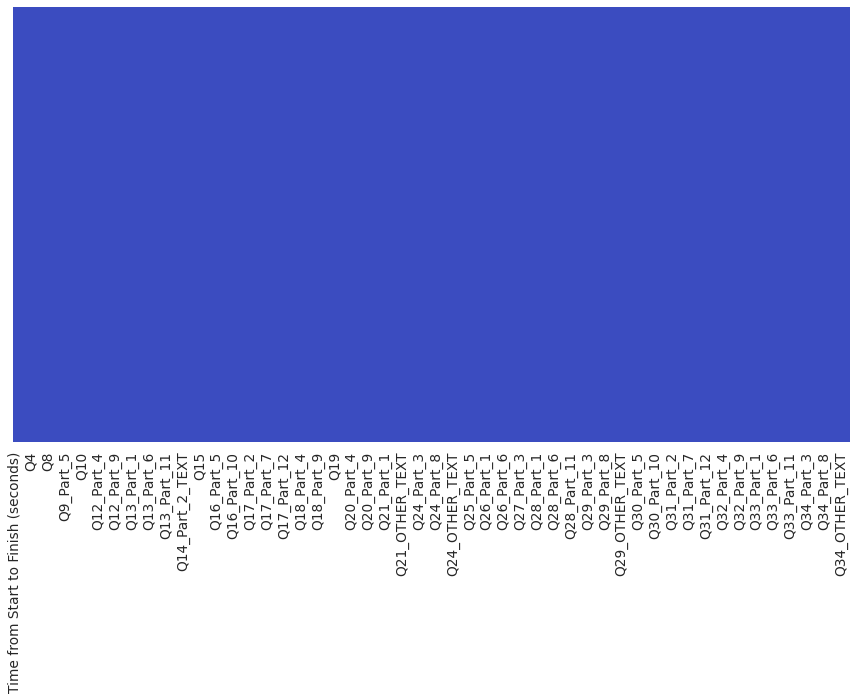

In [67]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)

### Data Conversion

Many machine learning models can only handle numeric features, so ordinal and categorical data are converted to numerical data. We first find the columns in which the data reported are not numeric.

In [68]:
df.select_dtypes(exclude=np.number).head()

Q1    Q2         Q3  ... Q34_Part_11 Q34_Part_12    Q10_buckets
0  22-24  Male     France  ...           0           0  30,000-39,999
1  40-44  Male      India  ...           0           0        0-9,999
2  40-44  Male  Australia  ...           0           0       >250,000
3  22-24  Male      India  ...           0           0        0-9,999
4  50-54  Male     France  ...           0           0  60,000-69,999

[5 rows x 218 columns]

#### "Select all that apply" Questions

As previously mentioned, the null responses are filled with "0". If survey respondents had selected an option, a string is seen in the dataset. As a result, for each Part_# corresponding to a "Select all that apply" question:


*   If the data is not "0", replace with "1"
*   Otherwise, remain the same


However, the responses of survey respondents are recorded differently under OTHER_TEXT parts. If a survey respondednt had not selected the "Other" option, the corresponding value in the column is "-1". Values that are not "-1" indicate a survey respondednt had selected this option. As a result, for each OTHER_TEXT part corresponding to a question:


*   If the data is "-1", replace with "0"
*   Otherwise, replace with "1"

In [0]:
col_names = df.columns.to_list()

for i in range(1, df.shape[1] - 2):
  if len(col_names[i]) > 12: # OTHER_TEXT columns
    df.iloc[:, i] = df.iloc[:, i].where(df.iloc[:, i] == -1, 1) # not equal to -1, replace with 1
    df.iloc[:, i] = df.iloc[:, i].where(df.iloc[:, i] != -1, 0) # equal to -1, replace with 0
  elif len(col_names[i]) > 4: # Part_# columns
    df.iloc[:, i] = df.iloc[:, i].where(df.iloc[:, i] == 0, 1) # not equal to 0, replace with 1

In [70]:
# Verify
df.head()

Time from Start to Finish (seconds)     Q1  ... Q10_Encoded    Q10_buckets
0                                  510  22-24  ...           3  30,000-39,999
1                                  423  40-44  ...           0        0-9,999
2                                  391  40-44  ...          14       >250,000
3                                  392  22-24  ...           0        0-9,999
4                                  470  50-54  ...           6  60,000-69,999

[5 rows x 248 columns]

#### Ordinal Categorical Data

Q4 asks survey respondents for their highest level of formal education. The answer options include order. As a result, they are encoded using the number of years of education to represent their order:


*   (0) I prefer not to answer
*   (12) No formal education past high school

*   (14) Some college/university study without earning a bachelor’s degree
*   (16) Bachelor’s degree

*   (18) Master’s degree
*   (20) Professional degree

*   (21) Doctoral degree









In [71]:
df['Q4'].value_counts()

Master’s degree                                                      5868
Bachelor’s degree                                                    3361
Doctoral degree                                                      2083
Professional degree                                                   462
Some college/university study without earning a bachelor’s degree     414
I prefer not to answer                                                184
No formal education past high school                                  125
Name: Q4, dtype: int64

In [0]:
# Encode highest level of education in 'Q4' to # of years of education
df['Q4'] = df['Q4'].map({
    'I prefer not to answer': 0, 
    'No formal education past high school': 12, 
    'Some college/university study without earning a bachelor’s degree': 14, 
    'Bachelor’s degree': 16, 
    'Master’s degree':18, 
    'Professional degree': 20,
    'Doctoral degree': 21})

In [73]:
# Verify
df['Q4'].value_counts()

18    5868
16    3361
21    2083
20     462
14     414
0      184
12     125
Name: Q4, dtype: int64

Q8 asks survey respondents for the incorporation of ML methods at their company. the answer options also include order. As a result, they are encoded using numbers from 0 to 5 to represent their order:

*   (0) I do not know
*   (1) No (we do not use ML methods)

*   (2) We are exploring ML methods (and may one day put a model into production)
*   (3) We use ML methods for generating insights (but do not put working models into production)

*   (4) We recently started using ML methods (i.e., models in production for less than 2 years)
*   (5) We have well established ML methods (i.e., models in production for more than 2 years)

In [74]:
df['Q8'].value_counts()

We are exploring ML methods (and may one day put a model into production)                    2636
We recently started using ML methods (i.e., models in production for less than 2 years)      2589
We have well established ML methods (i.e., models in production for more than 2 years)       2362
No (we do not use ML methods)                                                                2345
We use ML methods for generating insights (but do not put working models into production)    1448
I do not know                                                                                1117
Name: Q8, dtype: int64

In [0]:
# Encode machine learning use in company in 'Q8' to ordinal classes
df['Q8'] = df['Q8'].map({
    'I do not know': 0, 
    'No (we do not use ML methods)': 1, 
    'We are exploring ML methods (and may one day put a model into production)': 2, 
    'We use ML methods for generating insights (but do not put working models into production)': 3, 
    'We recently started using ML methods (i.e., models in production for less than 2 years)': 4, 
    'We have well established ML methods (i.e., models in production for more than 2 years)': 5})

In [76]:
# Verify
df['Q8'].value_counts()

2    2636
4    2589
5    2362
1    2345
3    1448
0    1117
Name: Q8, dtype: int64

#### Ordinal Categorical Data with Numerical Components

For columns Q1, Q6, Q7, Q11, Q15, Q22, and Q23, the answer options include numbers. Each option is then encoded with the average of the lower and upper boundary, except for ones with 'number+' (eg. 20+) or '> number' (eg. > 10,000), where the number is directly taken. Note for Q6, Q7, and Q22, if the average of two boundaries return a decimal number, the number is rounded (cannot have 0.5 of a person or use). The Q10 and Q10_buckets columns are not converted as they have already been encoded with the results in the Q10_Econded column.

In [0]:
# Encode age options in 'Q1' to average age in each option
df['Q1'] = df['Q1'].map({
    '18-21': 19.5, '22-24': 23, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42, '45-49': 47, '50-54': 52, '55-59': 57, '60-69': 64.5, '70+': 70})

# Encode company size options in 'Q6' to average # of employees in each option
df['Q6'] = df['Q6'].map({
    '0-49 employees': 25, '50-249 employees': 150, '250-999 employees': 625, '1000-9,999 employees': 5500, '> 10,000 employees': 10000})

# Encode # of employees responsible for DS at company options in 'Q7' to average # of employees in each option
df['Q7'] = df['Q7'].map({
    '0': 0, '1-2': 2, '3-4': 4, '5-9': 7, '10-14': 12, '15-19': 17, '20+': 20})

# Encode money spent on ML options in 'Q11' to average amount in each option
df['Q11'] = df['Q11'].map({
    '$0 (USD)': 0, '$1-$99': 50, '$100-$999': 549.5, '$1000-$9,999': 5499.5, '$10,000-$99,999': 54999.5, '> $100,000 ($USD)': 100000})

# Encode years writing code options in 'Q15' to average # of years in each option
df['Q15'] = df['Q15'].map({
    'I have never written code': 0, '< 1 years': 1, '1-2 years': 1.5, '3-5 years': 4, '5-10 years': 7.5, '10-20 years': 15, '20+ years': 20})

# Encode use of TPU options in 'Q22' to average # of uses in each option
df['Q22'] = df['Q22'].map({
    'Never': 0, 'Once': 1, '2-5 times': 3.5, '6-24 times': 15, '> 25 times': 25})

# Encode years of ML use options 'Q23' to average years of use in each option
df['Q23'] = df['Q23'].map({
    '< 1 years': 1, '1-2 years': 1.5, '2-3 years': 2.5, '3-4 years': 3.5, '4-5 years': 4.5, '5-10 years': 7.5, '10-15 years': 12.5, '20+ years': 20})

In [78]:
# Verify
df.head()

Time from Start to Finish (seconds)    Q1  ... Q10_Encoded    Q10_buckets
0                                  510  23.0  ...           3  30,000-39,999
1                                  423  42.0  ...           0        0-9,999
2                                  391  42.0  ...          14       >250,000
3                                  392  23.0  ...           0        0-9,999
4                                  470  52.0  ...           6  60,000-69,999

[5 rows x 248 columns]

#### Other Categorical Data

For columns that contain only text responses with no order, one hot encoding is used to convert them to numerical data. But first, some of the columns are checked to see if a few of the options could be grouped together. Although less features will be created through one hot encoding, some information are lost along the way.

In [79]:
df['Q2'].value_counts()

Male                       10473
Female                      1827
Prefer not to say            167
Prefer to self-describe       30
Name: Q2, dtype: int64

For Q2, we group survey respondents that did not identify with either male or female into "Other".

In [0]:
df['Q2'] = df['Q2'].replace(['Prefer not to say', 'Prefer to self-describe'], 'Other')

In [81]:
df['Q3'].value_counts()

India                                                   2477
United States of America                                2134
Other                                                    705
Brazil                                                   535
Japan                                                    480
Russia                                                   426
Germany                                                  360
United Kingdom of Great Britain and Northern Ireland     333
Spain                                                    316
Canada                                                   301
France                                                   279
China                                                    235
Nigeria                                                  215
Australia                                                208
Italy                                                    197
Turkey                                                   173
Taiwan                  

There are too many countries listed in Q3. Instead, we keep the top two countries in which survey respondents identified with and categorize the others based on which continent they belong to. 

In [0]:
df['Q3'] = df['Q3'].replace(['Nigeria','Kenya','Morocco','Algeria','Tunisia', 'Egypt', 'South Africa'], 'Africa')
df['Q3'] = df['Q3'].replace(['Japan','China','Taiwan','Pakistan','South Korea','Indonesia','Singapore','Israel','Viet Nam','Bangladesh','Iran, Islamic Republic of...',
                             'Hong Kong (S.A.R.)','Malaysia','Republic of Korea','Thailand','Philippines','Saudi Arabia'], 'Asia')
df['Q3'] = df["Q3"].replace(['France', 'Netherlands', 'Germany', 'Ireland', 'Russia', 'Greece', 'Ukraine', 'Belarus', 'United Kingdom of Great Britain and Northern Ireland', 
                             'Sweden', 'Portugal', 'Poland', 'Italy', 'Czech Republic', 'Spain', 'Turkey','Hungary', 'Norway','Switzerland', 
                             'Singapore', 'Romania','Belgium', 'Austria', 'Denmark'], 'Europe')
df['Q3'] = df['Q3'].replace(['Mexico', 'Canada'], 'North America')
df['Q3'] = df['Q3'].replace(['Brazil', 'Colombia', 'Argentina', 'Chile', 'Peru'], 'South America')
df['Q3'] = df['Q3'].replace(['Australia', 'New Zealand'], 'Oceania')

The remaining columns are left as is. For Q14, the part_# and OTHER_TEXT columns are dropped as one hot encoding is applied on it. 

In [0]:
# For plotting purposes later
df_age = df['Q1']
df_gender = df['Q2']
df_country = df['Q3']

In [0]:
df = df.drop(columns=['Q14_Part_1_TEXT', 'Q14_Part_2_TEXT', 'Q14_Part_3_TEXT', 'Q14_Part_4_TEXT', 'Q14_Part_5_TEXT', 'Q14_OTHER_TEXT'])

In [0]:
df = pd.get_dummies(df, columns=['Q2'], prefix='Q2Gender')
df = pd.get_dummies(df, columns=['Q3'], prefix='Q3Country')
df = pd.get_dummies(df, columns=['Q5'], prefix='Q5Occupation')
df = pd.get_dummies(df, columns=['Q14'], prefix='Q14Tool')
df = pd.get_dummies(df, columns=['Q19'], prefix='Q19PLanguage')

After one hot encoding, the OTHER_TEXT part of questions are dropped as they are already incorporated into the responses in the main column. 

In [0]:
df = df.drop(columns='Q2_OTHER_TEXT')
df = df.drop(columns='Q5_OTHER_TEXT')
df = df.drop(columns='Q19_OTHER_TEXT')

In [87]:
# Verify
print(df.head().to_string())

   Time from Start to Finish (seconds)    Q1  Q4     Q6  Q7  Q8 Q9_Part_1 Q9_Part_2 Q9_Part_3 Q9_Part_4 Q9_Part_5 Q9_Part_6 Q9_Part_7 Q9_Part_8  Q9_OTHER_TEXT              Q10       Q11 Q12_Part_1 Q12_Part_2 Q12_Part_3 Q12_Part_4 Q12_Part_5 Q12_Part_6 Q12_Part_7 Q12_Part_8 Q12_Part_9 Q12_Part_10 Q12_Part_11 Q12_Part_12  Q12_OTHER_TEXT Q13_Part_1 Q13_Part_2 Q13_Part_3 Q13_Part_4 Q13_Part_5 Q13_Part_6 Q13_Part_7 Q13_Part_8 Q13_Part_9 Q13_Part_10 Q13_Part_11 Q13_Part_12  Q13_OTHER_TEXT   Q15 Q16_Part_1 Q16_Part_2 Q16_Part_3 Q16_Part_4 Q16_Part_5 Q16_Part_6 Q16_Part_7 Q16_Part_8 Q16_Part_9 Q16_Part_10 Q16_Part_11 Q16_Part_12  Q16_OTHER_TEXT Q17_Part_1 Q17_Part_2 Q17_Part_3 Q17_Part_4 Q17_Part_5 Q17_Part_6 Q17_Part_7 Q17_Part_8 Q17_Part_9 Q17_Part_10 Q17_Part_11 Q17_Part_12  Q17_OTHER_TEXT Q18_Part_1 Q18_Part_2 Q18_Part_3 Q18_Part_4 Q18_Part_5 Q18_Part_6 Q18_Part_7 Q18_Part_8 Q18_Part_9 Q18_Part_10 Q18_Part_11 Q18_Part_12  Q18_OTHER_TEXT Q20_Part_1 Q20_Part_2 Q20_Part_3 Q20_Part_4 Q20_Part_

Furthermore, as the target variable has already been encoded, the columns Q10 and Q10_buckets are dropped.

In [0]:
df = df.drop(columns='Q10')
df = df.drop(columns='Q10_buckets')

## Exploratory Data Analysis

### Data Trends

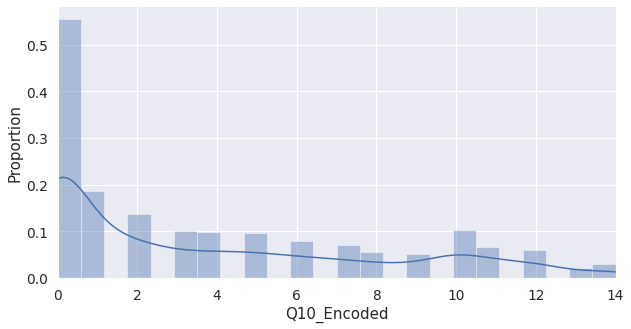

In [89]:
# Distribution of different salary buckets
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['Q10_Encoded'], ax=ax)
plt.ylabel("Proportion")
plt.xlim(0, 14)
plt.show()

From the plot, we can see that there is an imbalance in the target variable. As a result, the data is skewed as most of the survey respondents earn a salary in the first bucket, which is $0 - 9,999 USD.

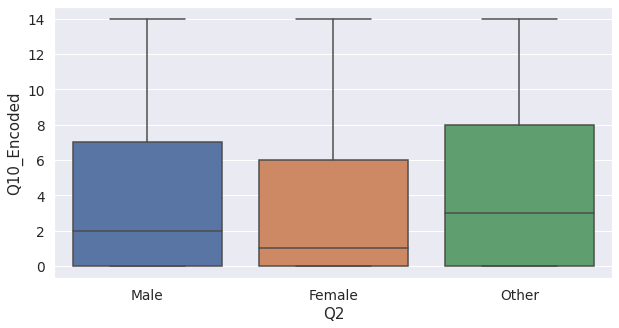

In [90]:
# Boxplot of Gender vs Salary
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=df_gender, y=df['Q10_Encoded'], ax=ax)
plt.show()

Although sometimes we may not want to agree, but gender appears to impact salary. The plot above indicates that females on average earn lower than males. However, it is interesting to note that the "Other" category had higher earnings than both males and females. However, due to the low number of survey participants that identified with this category, it is hard to say for sure. 

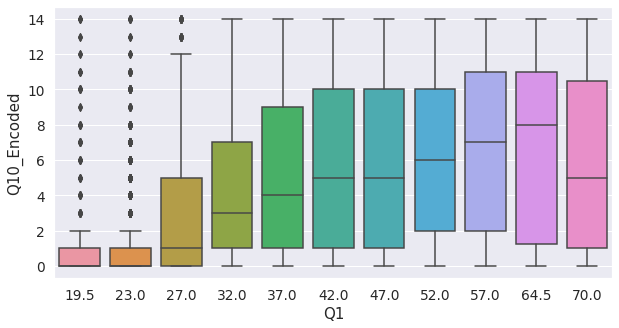

In [91]:
# Boxplot of Age vs Salary
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=df_age, y=df['Q10_Encoded'], ax=ax)
plt.show()

We expect that age is correlated with a person's salary. Normally, the older a person is, the more experience he or she has in the field, which will impact salary. As expected, there is an increasing trend in salary as age increases. However, there is a decrease in salary at 70 years of age. This could be due to the fact that most people will be retired by then and may not be working full-time. 

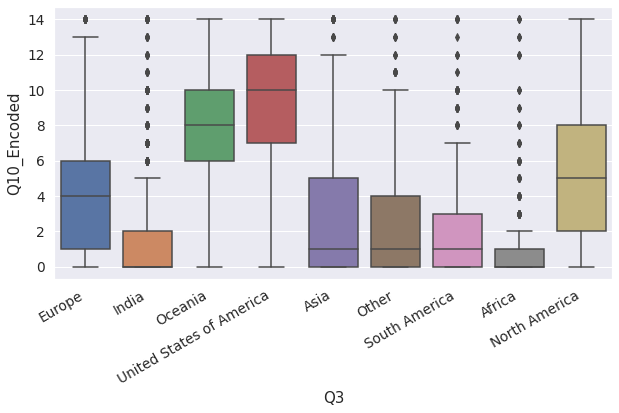

In [92]:
# Boxplot of Country vs Salary
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=df_country, y=df['Q10_Encoded'], ax=ax).set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

From the above plot, we see that survey respondents from the US have the highest earnings, followed by Oceania. Europe and North America have similar median earnings but different 25th and 75th percentile earnings. Asia, South America, and Other follows after, with India and Africa having the lowest salary. Again, we expected these results as top earning countries/continents are mostly developed, while the lower earning countries/continents are mostly developing. However, it is interesting to note the large difference in salary between other North American countries and US. 

### Feature Importance

To visualize feature importance, the correlation plot is plotted. 

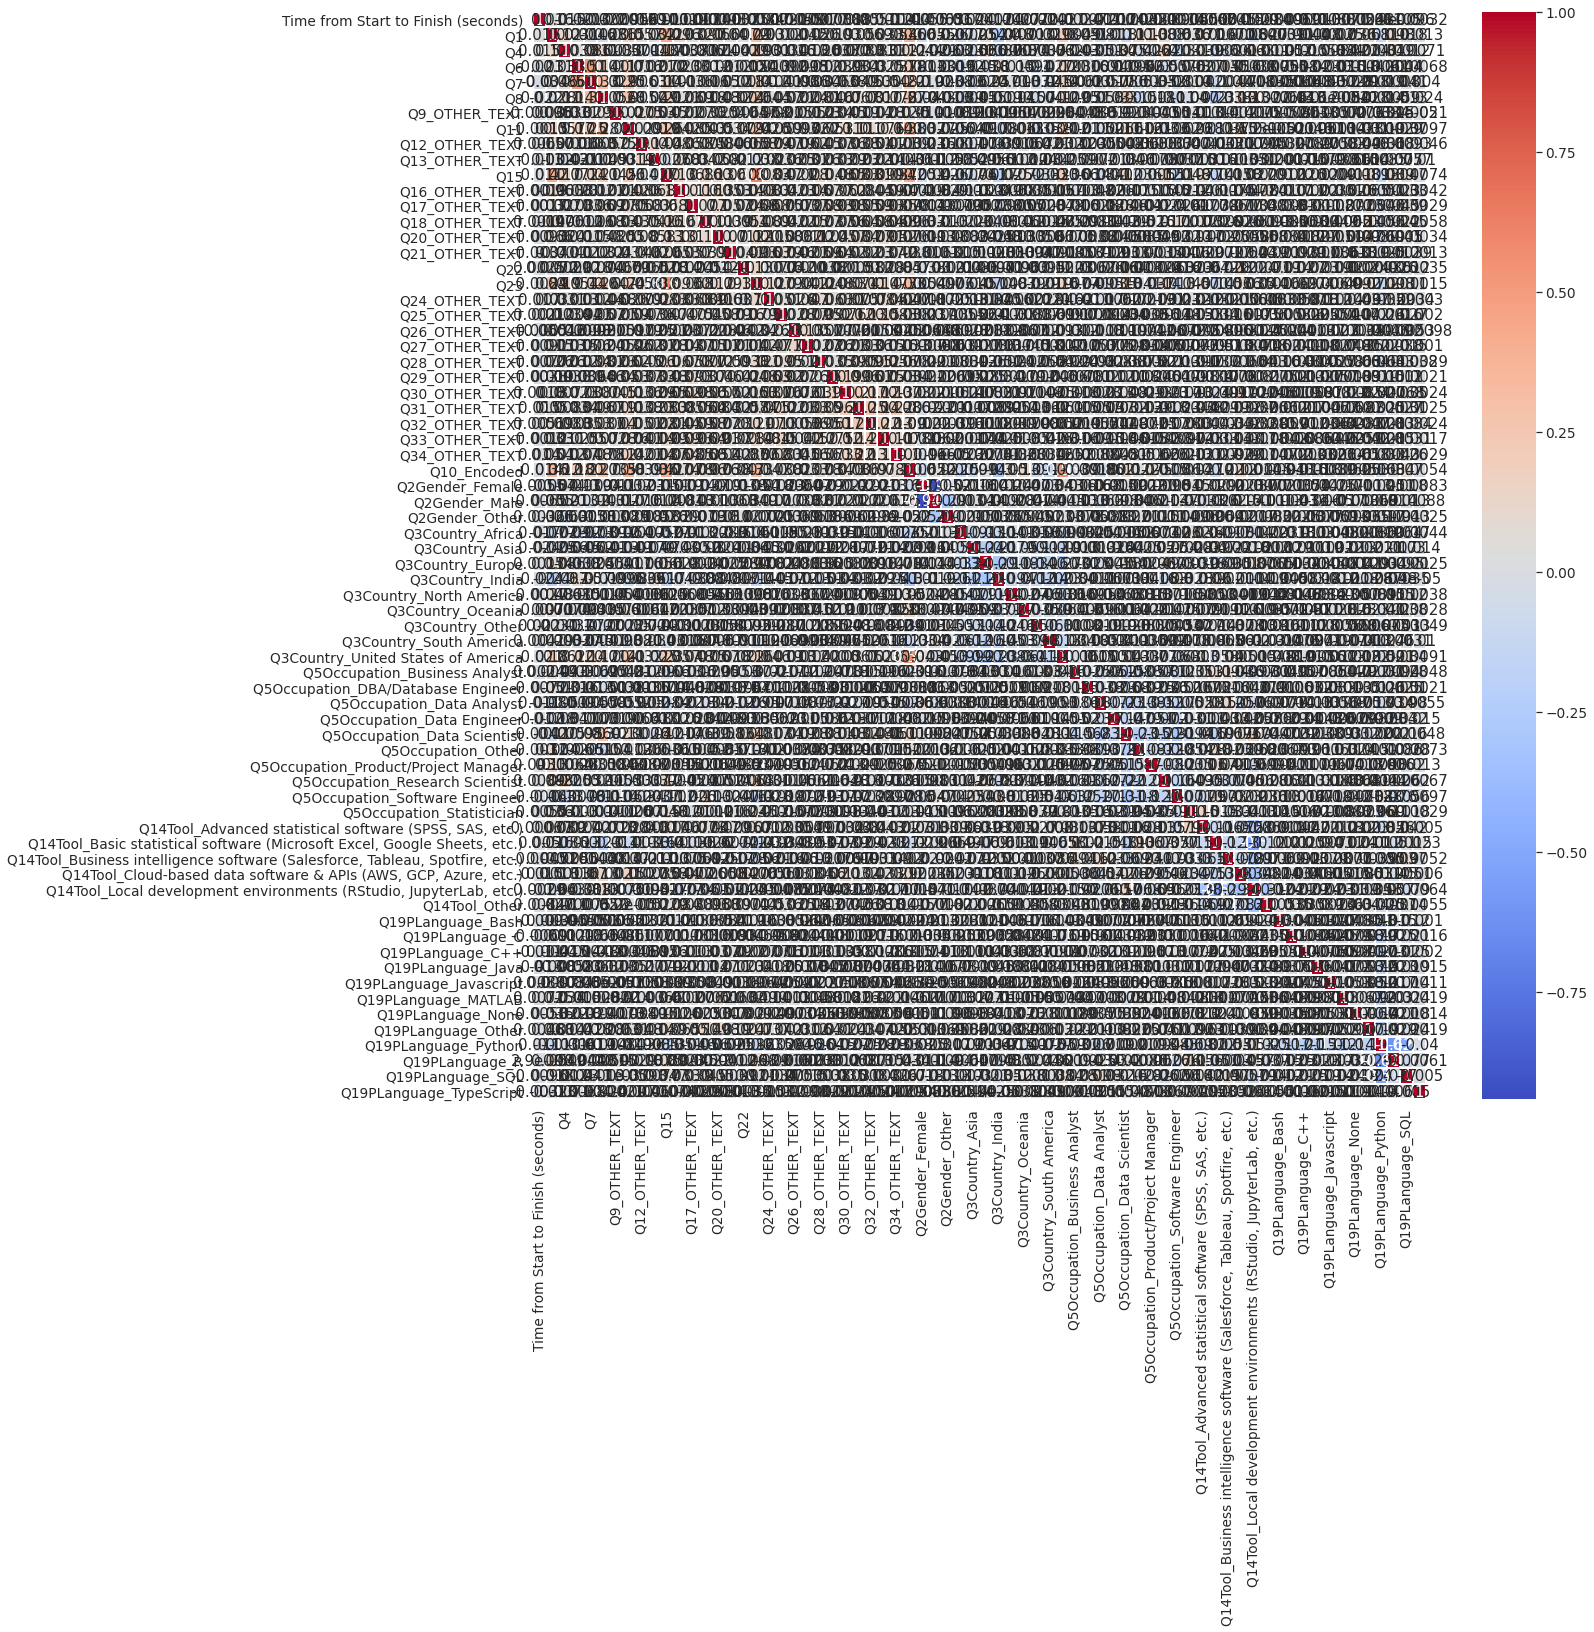

In [93]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, linewidths=1)
plt.show()

Looking at the correlation of all the features from the above plot is too difficult due to the volume of features. As a result, we focus on the top 30 most highest ranked features based on correlation.

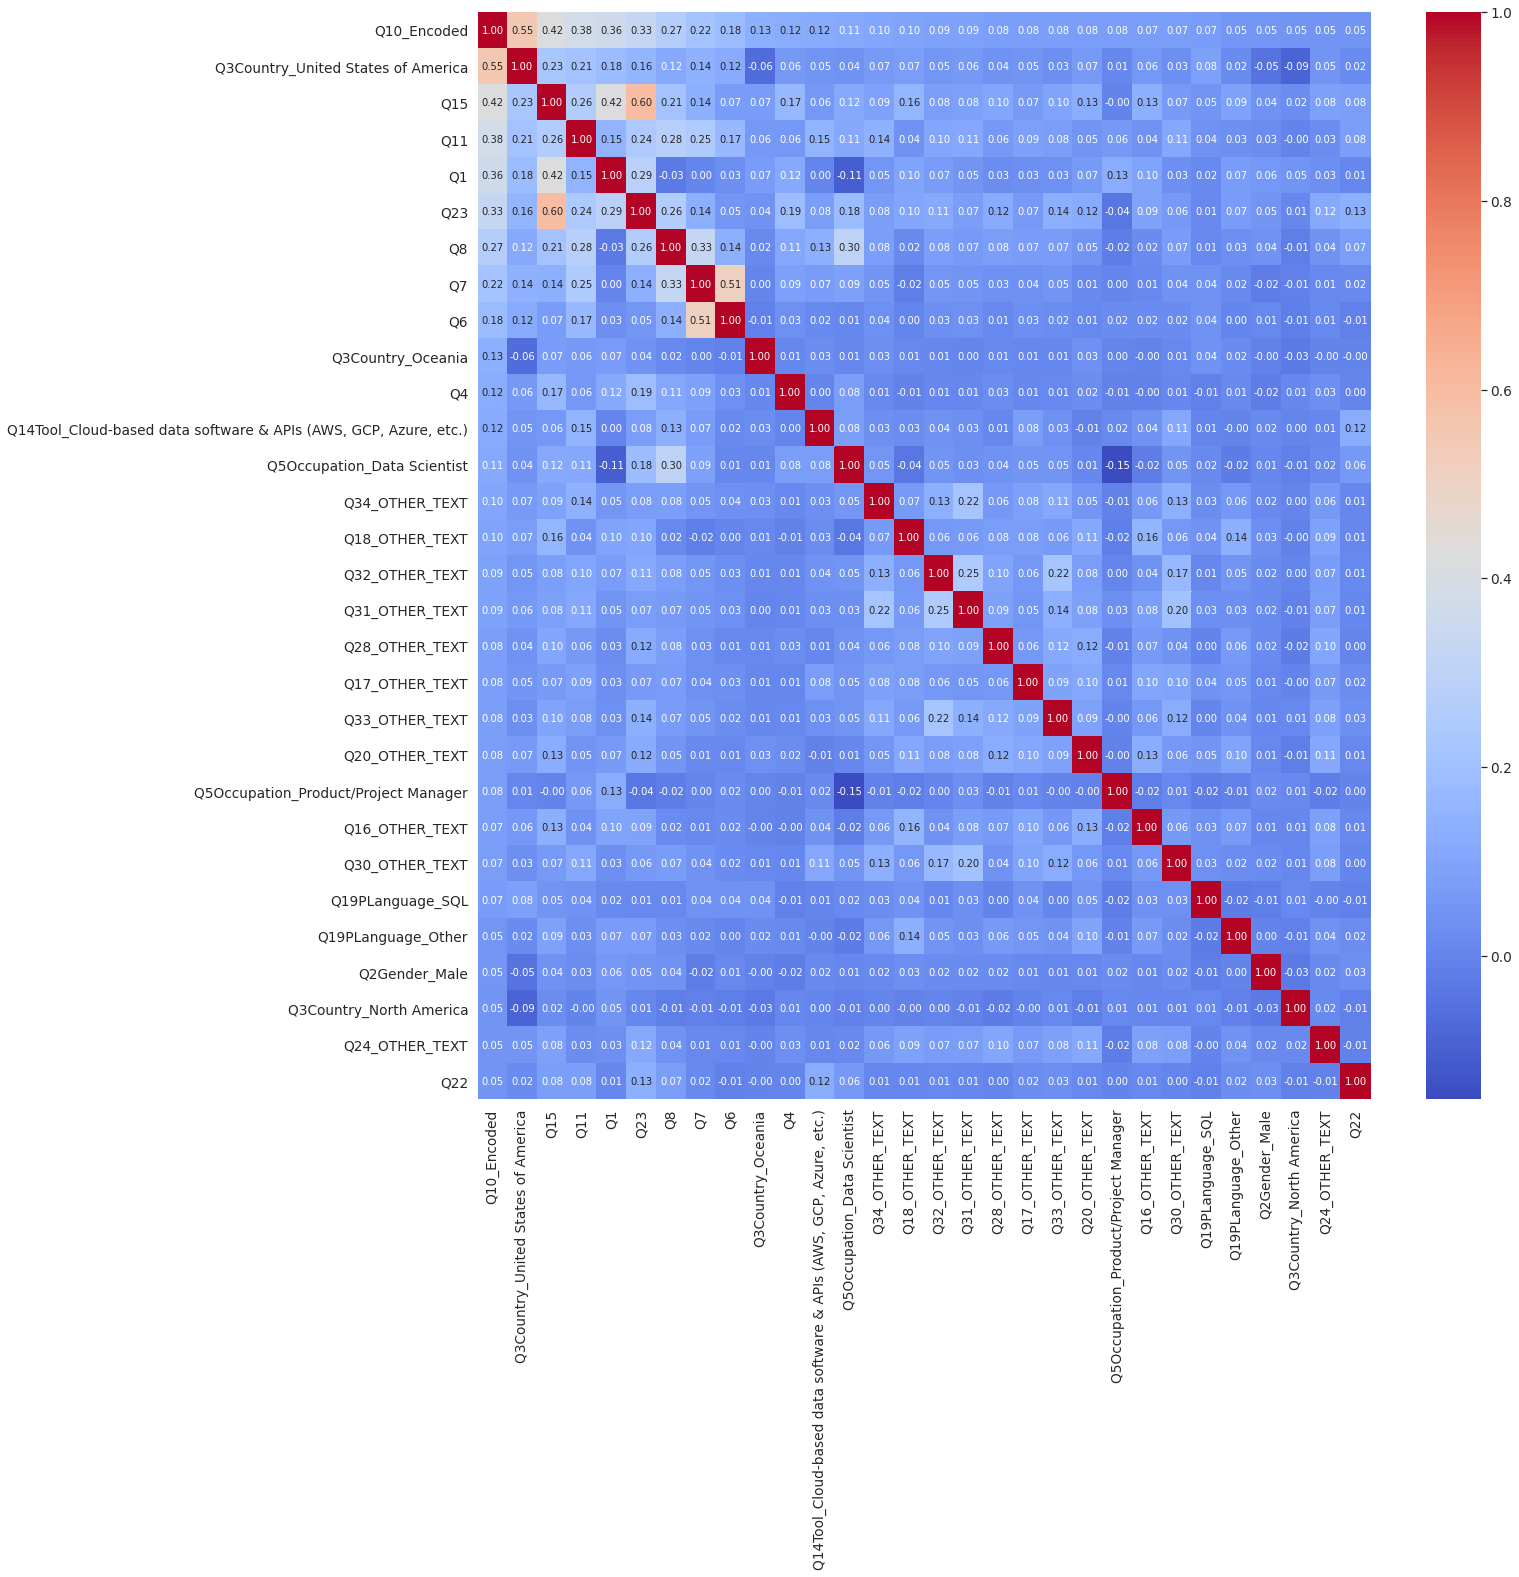

In [94]:
k=30
f, ax = plt.subplots(figsize=(20,20))
cols = df.corr().nlargest(k, 'Q10_Encoded')['Q10_Encoded'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [95]:
# For ppt slide purposes 
'''
k=10
f, ax = plt.subplots(figsize=(7,7))
cols = df.corr().nlargest(k, 'Q10_Encoded')['Q10_Encoded'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
'''

"\nk=10\nf, ax = plt.subplots(figsize=(7,7))\ncols = df.corr().nlargest(k, 'Q10_Encoded')['Q10_Encoded'].index\ncm = np.corrcoef(df[cols].values.T)\nsns.set(font_scale=1.25)\nhm = sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)\nplt.show()\n"

From the above correlation plot, the top 5 most correlated features in descending order, are:

*   Whether the survey respondent is from the US (Q3)
*   Number of years they have been writing code (Q15)

*   Amount of money spent on ML/cloud computing at work (Q11)
*   Age (Q1)

*   Number of years using ML methods (Q23)

The features 'Age' and 'Country' are expected as indicated by the plots from the previous section. Furthermore, the remaining features all relate to experience in performing related work.



## Feature Selection

By definition, feature engineering is the task of transforming the feature space in a given learning problem to improve the performance of a trained model. It is used to prepare features that could be best utilized by machine learning models. It also includes the process of selecting the most relevant features to the target variable. Having good features will aid in finding meaningful insights from our models. As a result, features should be carefully selected depending on the specific problem at hand.

### Feature Selection Model

The Recursive Feature Engineering Cross-Validation (RFECV) selector model within sckit-learn is used to conduct feature selection. This model can identify the attributes, as well as the combination of attributes, that best predict the target class based on calculated model accuracy. The estimator chosen is Lasso which has automatic feature selection built into it by acknowledging features with a coefficient of zero. 

In [0]:
X = df.loc[:, df.columns!='Q10_Encoded']
y = df['Q10_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # splitting into training and testing data

In [0]:
estimator = Lasso()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, y_train)
ranking = selector.ranking_ # ranking of features

In [0]:
X_selected = []
for i in range(len(ranking)):
  if ranking[i] <= 35:
    X_selected.append(i) # only append features that have a ranking equal to or less than 35

X_train = X_train.iloc[:, X_selected]
X_test = X_test.iloc[:, X_selected]

In [107]:
X_train.shape

(8747, 49)

From the feature selection model, the number of features chosen is 49. 

## Model Implementation

### Model Creation

A multiclass ordinal logistic regression model using 10-fold cross-validation is implemented. As the target variable contains 15 classes, to accomplish multiclass ordinal logistic regression, we fit 14 binary logistic regression classifers to obtain the highest probability of the salary class in which a survey respondent is in. 

In [0]:
def MultiOrdinalLogisticRegression_fit(X, y, y_class, C):

  binary_clfs = {}
 
  for i in range(y_class.shape[0]-1):
    binary_y = np.multiply((y > y_class[i]), 1) # assign 0 or 1 based on the condition
    binary_clfs[i] = LogisticRegression(C=C).fit(X, binary_y) # fit logistic regression model
  
  return binary_clfs

def MultiOrdinalLogisticRegression_predict(X, binary_clfs):
    
  predicted = {y: binary_clfs[y].predict_proba(X) for y in binary_clfs} # the probability of each data point belonging to 0 or 1
  predicted_result = []

  for i in y_class: # finding the probability of each data point belonging to each salary class and appending to predicted_result
    if i == 0:
      predicted_result.append(1 - predicted[i][:,1])
    elif i in predicted:
      predicted_result.append(predicted[i-1][:,1] - predicted[i][:,1])
    else:
      predicted_result.append(predicted[i-1][:,1])
    
  predicted_result = np.vstack(predicted_result).T
  
  return np.argmax(predicted_result, axis=1), predicted_result

### Model Use with 10-Fold Cross-Validation

In [110]:
  # 10 folds cross-validation with created model
  kF = KFold(n_splits=10)
  scaler = StandardScaler()
  C = 1 # default C in logistic regression model

  accuracy = np.zeros(10)
  np_idx = 0

  for train_idx, test_idx in kF.split(X_train): # define train and validation sets
    Xt_train, Xt_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    yt_train, yt_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    Xt_train = scaler.fit_transform(Xt_train) # fitting and standardizing training data
    Xt_test = scaler.transform(Xt_test) # standardizing testing data
    y_class = np.sort(np.unique(yt_train)) # obtain sorted classes in target variable

    clfs = MultiOrdinalLogisticRegression_fit(Xt_train, yt_train, y_class, C)
    y_pred, pred_prob = MultiOrdinalLogisticRegression_predict(Xt_test, clfs)

    accuracy[np_idx] = accuracy_score(yt_test, y_pred) * 100

    np_idx += 1
    print("Fold {}: Accuracy = {}%" .format(np_idx, round((accuracy[np_idx-1]), 3)))
    #print(classification_report(yt_test, y_pred, digits=3))

  cv_score = np.mean(accuracy)
  cv_var = np.var(accuracy)

  print("Cross-validation score: {}% ({}%)" .format(round(cv_score, 3), round(cv_var, 3)))

Fold 1: Accuracy = 34.743%
Fold 2: Accuracy = 37.029%
Fold 3: Accuracy = 35.886%
Fold 4: Accuracy = 36.343%
Fold 5: Accuracy = 35.771%
Fold 6: Accuracy = 36.8%
Fold 7: Accuracy = 36.0%
Fold 8: Accuracy = 39.245%
Fold 9: Accuracy = 35.812%
Fold 10: Accuracy = 34.439%
Cross-validation score: 36.207% (1.603%)


From the kfold cross-validation results, the accuracy amongst the different folds are relatively consistent, with a variance of less than 2%. 

### Varied Hyperparameter Values

We tune the hyperparameter C on our overall model. C = 1/lambda. As the value of C increases, the model complexity increases. As C increases, bias term decreases, increasing the probability of overfitting, but variance increases, increasing the prbability underfitting. As a result, we want to minimize bias-variance tradeoff by finding the best C. 

In [0]:
def Kfold(X, y, C): # as explained in previous kfold code
  kF = KFold(n_splits=10)
  scaler = StandardScaler()

  accuracy = np.zeros(10)
  np_idx = 0

  for train_idx, test_idx in kF.split(X_train):
    Xt_train, Xt_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    yt_train, yt_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    Xt_train = scaler.fit_transform(Xt_train)
    Xt_test = scaler.transform(Xt_test)
    y_class = np.sort(np.unique(yt_train)) 

    clfs = MultiOrdinalLogisticRegression_fit(Xt_train, yt_train, y_class, C)
    y_pred, pred_prob = MultiOrdinalLogisticRegression_predict(Xt_test, clfs)

    accuracy[np_idx] = accuracy_score(yt_test, y_pred) * 100

    np_idx += 1
    #print(classification_report(yt_test, y_pred, digits=3))

  cv_score = np.mean(accuracy)
  cv_var = np.var(accuracy)

  print("Cross-validation score: {}% ({}%)" .format(round(cv_score, 5), round(cv_var, 5)))

  return cv_score

In [112]:
C = [0.001,0.01,0.05,0.1,0.5,1,5,10]
cv_scores = []

for i in range(len(C)):
  print("C = {}" .format(C[i]))
  cv_score = Kfold(X_train, y_train, C=C[i])
  cv_scores.append(cv_score)

C = 0.001
Cross-validation score: 34.99491% (2.17493%)
C = 0.01
Cross-validation score: 36.1839% (2.18435%)
C = 0.05
Cross-validation score: 36.27544% (1.74737%)
C = 0.1
Cross-validation score: 36.25254% (1.46103%)
C = 0.5
Cross-validation score: 36.21824% (1.55109%)
C = 1
Cross-validation score: 36.2068% (1.60334%)
C = 5
Cross-validation score: 36.21823% (1.57106%)
C = 10
Cross-validation score: 36.21823% (1.57106%)


Text(0, 0.5, 'Accuracy (%)')

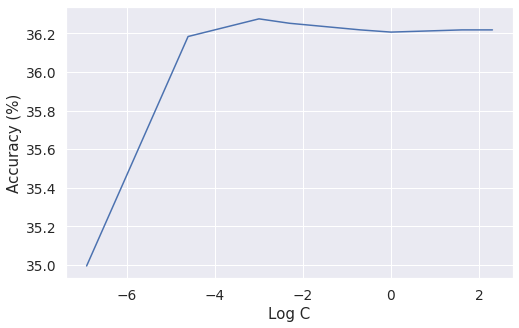

In [113]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.log(C), cv_scores)
plt.xlabel("Log C")
plt.ylabel("Accuracy (%)")

From the values and the plot above, the highest accuracy occured for the model where C = 0.05. 

## Model Tuning

Lambda corresponds to the regularizer in the loss function. For tuning, we chose to vary the hyperparameters C and 'solver' in the logistic regression models using grid search. The bias-variance tradeoff of each binarcy logistic regression model is taken into account to find the best hyperparameters for each model. The hyperparameters with the highest overall accuracy for each model were selected.

In [0]:
def GridSearch(X, y):

  model = LogisticRegression()
  scaler = StandardScaler()
  kF = KFold(n_splits=10)

  best_model = model
  best_params = {}
  best_accuracy = 0
  best_std = 0

  for C in [0.001,0.01,0.05,0.1,0.5,1,5,10]: # different C to be looked at
    for solver in ['newton-cg','lbfgs','liblinear','sag']: # different solvers to be looked at
        
      model = LogisticRegression(C=C, solver=solver, max_iter=1000)
      accuracy = np.zeros(10)
      np_idx = 0
        
      for train_idx, test_idx in kF.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        TN = confusion_matrix(y_test, predictions)[0][0]
        FP = confusion_matrix(y_test, predictions)[0][1]
        FN = confusion_matrix(y_test, predictions)[1][0]
        TP = confusion_matrix(y_test, predictions)[1][1]
        total = TN + FP + FN + TP
        ACC = (TP + TN) / float(total)

        accuracy[np_idx] = ACC * 100
        np_idx += 1
        #print("C = {}, solver = {}, fold = {}, accuracy = {}%" .format(C, solver, np_idx, round(accuracy[np_idx-1], 3)))
        
      if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_var = np.var(accuracy)     

  print ("The optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a variance of {}%\n".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_var,3)))

  return best_params

In [115]:
# finding the best hyperparameters for each of the logistic regressionl models
y_class = np.sort(np.unique(y_train))

best_params = {}

for i in range(y_class.shape[0]-1):
  binary_y = np.multiply((y_train > y_class[i]), 1)
  print("n = {}" .format(i+1))
  best_params[i] = GridSearch(X_train, binary_y)

n = 1
The optimal log model uses C=0.05, and a liblinear solver, and has a cross validation score of 78.336% with a variance of 2.892%

n = 2
The optimal log model uses C=0.001, and a newton-cg solver, and has a cross validation score of 78.267% with a variance of 1.502%

n = 3
The optimal log model uses C=0.01, and a newton-cg solver, and has a cross validation score of 79.239% with a variance of 0.718%

n = 4
The optimal log model uses C=0.01, and a newton-cg solver, and has a cross validation score of 80.53% with a variance of 1.881%

n = 5
The optimal log model uses C=0.05, and a liblinear solver, and has a cross validation score of 82.096% with a variance of 2.149%

n = 6
The optimal log model uses C=0.01, and a newton-cg solver, and has a cross validation score of 83.606% with a variance of 3.197%

n = 7
The optimal log model uses C=0.01, and a liblinear solver, and has a cross validation score of 85.926% with a variance of 1.147%

n = 8
The optimal log model uses C=0.05, and a n

In [0]:
# Hard code obtained best_params
best_params = {0: {'C': 0.05, 'solver': 'liblinear'},
 1: {'C': 0.001, 'solver': 'newton-cg'},
 2: {'C': 0.01, 'solver': 'newton-cg'},
 3: {'C': 0.01, 'solver': 'newton-cg'},
 4: {'C': 0.05, 'solver': 'liblinear'},
 5: {'C': 0.01, 'solver': 'newton-cg'},
 6: {'C': 0.01, 'solver': 'liblinear'},
 7: {'C': 0.05, 'solver': 'newton-cg'},
 8: {'C': 0.01, 'solver': 'liblinear'},
 9: {'C': 0.05, 'solver': 'newton-cg'},
 10: {'C': 0.01, 'solver': 'liblinear'},
 11: {'C': 0.001, 'solver': 'liblinear'},
 12: {'C': 0.5, 'solver': 'liblinear'},
 13: {'C': 0.05, 'solver': 'newton-cg'}}

The tuned logistic model is applied on our training data with 10-fold cross-validation.

In [0]:
def TunedMultiOrdinalLogisticRegression_fit(X, y, y_class, best_params):

  binary_clfs = {}
 
  if y_class.shape[0] > 2:
    for i in range(y_class.shape[0]-1):
      binary_y = np.multiply((y > y_class[i]), 1)
      binary_clfs[i] = LogisticRegression(C=best_params[i].get('C'), solver=best_params[i].get('solver'), max_iter=1000).fit(X, binary_y)
  
  return binary_clfs

In [118]:
kF = KFold(n_splits=10)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kF.split(X_train):
  Xt_train, Xt_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
  yt_train, yt_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

  Xt_train = scaler.fit_transform(Xt_train)
  Xt_test = scaler.transform(Xt_test)
  y_class = np.sort(np.unique(yt_train))

  clfs = TunedMultiOrdinalLogisticRegression_fit(Xt_train, yt_train, y_class, best_params)
  y_pred, pred_prob = MultiOrdinalLogisticRegression_predict(Xt_test, clfs)

  accuracy[np_idx] = accuracy_score(yt_test, y_pred) * 100

  np_idx += 1
  #print("Fold {}:" .format(np_idx,))
  #print(classification_report(yt_test, y_pred, digits=3))

cv_score = np.mean(accuracy)
cv_std = np.std(accuracy)

print("Cross-validation score: {}% ({}%)" .format(round(cv_score, 5), round(cv_std, 5)))

Cross-validation score: 32.73118% (1.21869%)


The results obtained on the training data are as follows:

*   C = 1 (default), cross-validation accuracy = 36.207%
*   Tuning C on overall model, highest cross-validation accuracy, 36.275% achieved when C = 0.05

*   After tuning C and 'solver' on each individual model, cross-validation accuracy = 32.731%

Although the best hyperparameters were chosen using grid search, the cross-validation accuracy did not increase, but the differences are very slight.






## Testing & Discussion

### Model Implementation on Test Data

In [0]:
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [120]:
y_class = np.sort(np.unique(y_train))
clfs = TunedMultiOrdinalLogisticRegression_fit(X_train, y_train, y_class, best_params)
y_pred, pred_prob = MultiOrdinalLogisticRegression_predict(X_test, clfs)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4951    0.8774    0.6330      1199
           1     0.1330    0.0623    0.0849       401
           2     0.2000    0.0066    0.0127       304
           3     1.0000    0.0045    0.0090       221
           4     0.2143    0.0148    0.0276       203
           5     0.0000    0.0000    0.0000       224
           6     0.4000    0.0247    0.0465       162
           7     0.2500    0.0065    0.0126       155
           8     0.0000    0.0000    0.0000       135
           9     0.0000    0.0000    0.0000       123
          10     0.2778    0.1101    0.1577       227
          11     0.1842    0.0467    0.0745       150
          12     0.0818    0.6950    0.1464       141
          13     0.2667    0.1081    0.1538        37
          14     0.2083    0.0735    0.1087        68

    accuracy                         0.3272      3750
   macro avg     0.2474    0.1353    0.0978      3750
weighted avg     0.3205   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


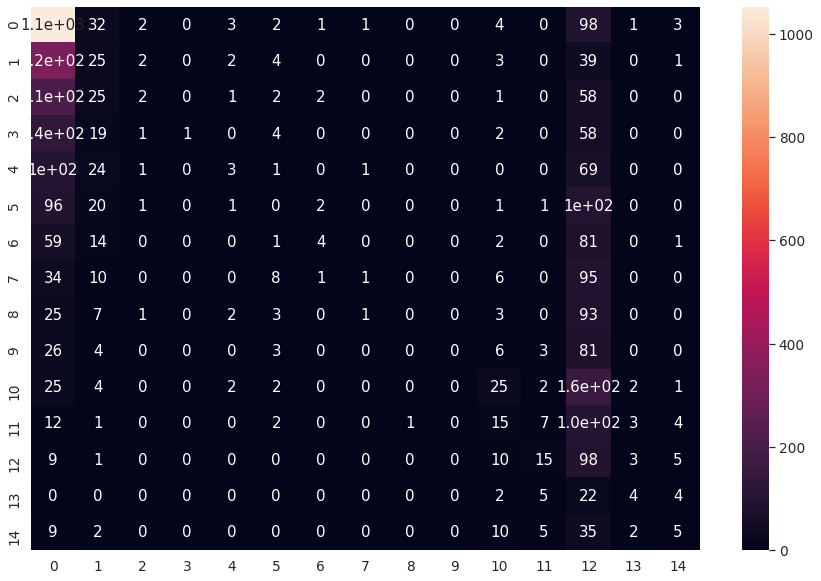

In [121]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(conf_matrix, range(15), range(15))
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True)
plt.show()

The accuracy for the testing set is 32.72%. This is similar to ones obtained on the training data from previous sections. As a result, the model has slightly overfitted when compared to the training data. But overall, the model performance is not great, suggesting an underfit due to the low accuracy score for predicting the salary class. This could be due to the the dataset being imbalanced in some of the features, such as:

*   Gender (more males)

*   Country (most respondents from US or India, but different GDP which affects amount of salary earned)

which may be viewed as potential outliers. Furthermore, as not all of the features were captured in the model, there could be underlying relationships that were not captured by the current model. 

For both the training and testing set, we could improve the accuracy by looking more closely at the data to determine outliers. For example, whether any young respondents (< 30 years of age) had reported having 20+ years of experience in writing code or in using machine learning. We could also minimize the scope of the model and instead predict the salary class for different subgroups of respondents categorized by eg. country, age group, etc. Additionally, we could further standardize our raw target variable as well as some of our features by taking into account of factors, such as GDP and demand for the occupation in the market. 







### Distribution of Salary Classes

The distribution of salary classes in the predicted target variable and in the actual target variable are plotted below. 

(0.0, 14.0)

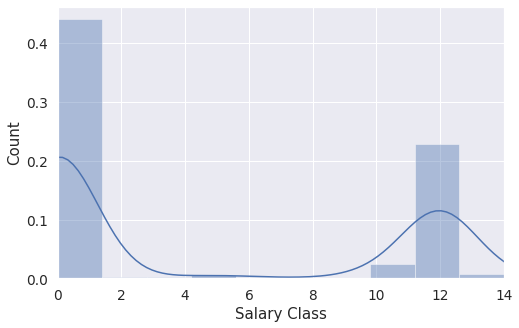

In [122]:
# Distribution of predicted salary class for test data
fig = plt.subplots(figsize=(8,5))
sns.distplot(y_pred)
plt.xlabel('Salary Class')
plt.ylabel('Count')
plt.xlim(0, 14)

(0.0, 14.0)

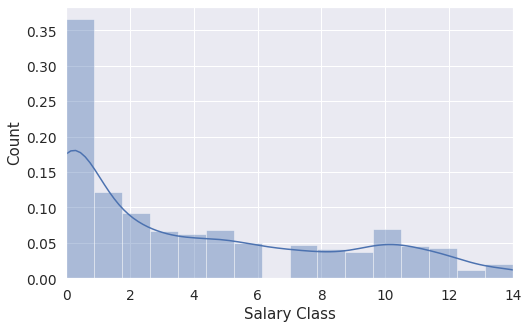

In [123]:
# Distribution of actual salary class for test data
fig = plt.subplots(figsize=(8,5))
sns.distplot(y_test)
plt.xlabel('Salary Class')
plt.ylabel('Count')
plt.xlim(0, 14)

We can see that the our model failed to predict many of the mid range salary classes.

### Additional Distribution Plots

We also looked at two random survey respondents and their probability of being in each of the salary class.

Text(0, 0.5, 'Predicted Probability')

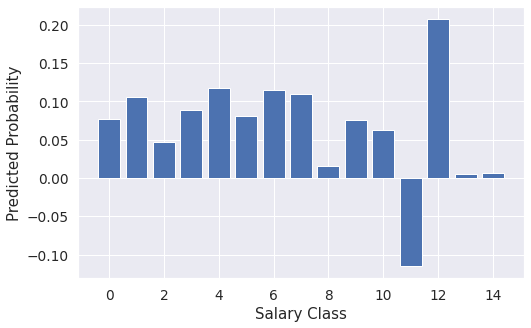

In [124]:
# First random survey respondent
fig = plt.subplots(figsize=(8,5))
plt.bar(y_class, pred_prob[100])
plt.xlabel("Salary Class")
plt.ylabel("Predicted Probability")

In [125]:
# Actual predicted class of the survey respondent
y_test.iloc[100]

6

Text(0, 0.5, 'Predicted Probability')

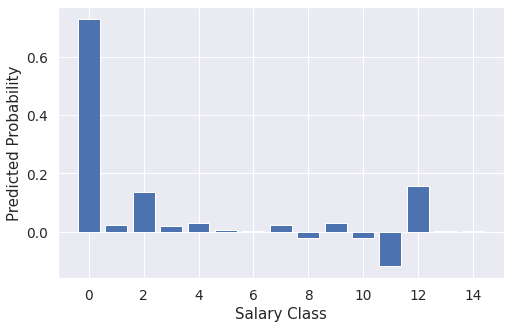

In [128]:
# Second random survey respondent
fig = plt.subplots(figsize=(8,5))
plt.bar(y_class, pred_prob[600])
plt.xlabel("Salary Class")
plt.ylabel("Predicted Probability")

In [129]:
# Actual predicted class of survey respondent
y_test.iloc[600]

0

The model correctly predicted one of the two survey respondents. More work could be done on the model to improve its performance. 